# Create Raster Template

In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import laspy
import geopandas as gpd
import rasterio # Rasters
from rasterio.transform import Affine # Transformations

# Visualization

import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Definitions

def save_geotiff(array, name, crs, resolution, minx, miny):
    '''Saves a numpy array into a geotiff.
    
    Give name as a string
    crs as int, resolution as int
    minx and miny both as floats
    '''
    transform = Affine.translation(minx - resolution / 2, miny - resolution / 2\
                              ) * Affine.scale(resolution, resolution)
    
    with rasterio.open(
        os.path.join(".", name + '.tif'),
        mode="w",
        driver="GTiff",
        height=array.shape[1],
        width=array.shape[0],
        count=1,
        dtype= 'float64',
        crs= rasterio.crs.CRS.from_epsg(crs),
        transform=transform,
    ) as new_dataset:
        new_dataset.write(array, 1)

In [3]:
# Get a list of tile_names

x_range = list(range(59,64))
y_range = list(range(28, 32))

tile_names = []

for x in x_range:
    for y in y_range:
        
        tile_name = '4342-' + str(y) + '-' + str(x) + '.las'
        
        tile_names += [tile_name]

In [4]:
# Explore using laspy...
# see: https://medium.com/spatial-data-science/an-easy-way-to-work-and-visualize-lidar-data-in-python-eed0e028996c
# or: https://laspy.readthedocs.io/en/latest/complete_tutorial.html

# An example of what laspy can do

tile_name = tile_names[1]
path = os.path.join('1_raw_data', 'LasTiles', tile_name)

las = laspy.read(path)

# Make into numpy 3d point cloud tensor

point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))

print('Shape', point_data.shape)
print('First entry', point_data[0])

# Classifications


#     2 Ground
#     5 Vegetation
#     6 – Building
#     8 – Model Keypoint (points required to maintain surface integrity).
#     9 – Water
#     10 – Breakline Proximity. Points within 3 meters of a breakline
#     12 – Overlap Points
#     14 – Bridge Decks

classifications = np.array(las.classification)

print('Unique Classifications', np.unique(classifications))

Shape (7447335, 3)
First entry [ 56511225 488267397     36850]
Unique Classifications [ 0  2  5  6  8  9 10 12]


In [5]:
# Find extent of all the tiles

minx = np.inf
miny = np.inf
maxx = np.NINF
maxy = np.NINF


water_x = np.empty((0), int) # Initialize water points storage to make sure we've got the right tiles (continuous)
water_y = np.empty((0), int)

for tile_name in tile_names:
    
    path = os.path.join('1_raw_data', 'LasTiles', tile_name)

    las = laspy.read(path)

    # Check extent of tile
    
    if min(las.X) < minx:
        minx = min(las.X)
    if min(las.Y) < miny:
        miny = min(las.Y)
    if max(las.X) > maxx:
        maxx = max(las.X)
    if max(las.Y) > maxy:
        maxy = max(las.Y)
 
    # Select Water points (checking for continuity)
    
    classifications = np.array(las.classification)

    water_indices = np.argwhere(classifications==9)
    
    water_x = np.append(water_x, las.X[water_indices])
    water_y = np.append(water_y, las.Y[water_indices])  
    

print('minx =', minx, 'miny =', miny, 'maxx =', maxx, 'maxy =', maxy)
print('These are in centimeters!!!')

minx = 56495713 miny = 487566062 maxx = 57761522 maxy = 488967939
These are in centimeters!!!


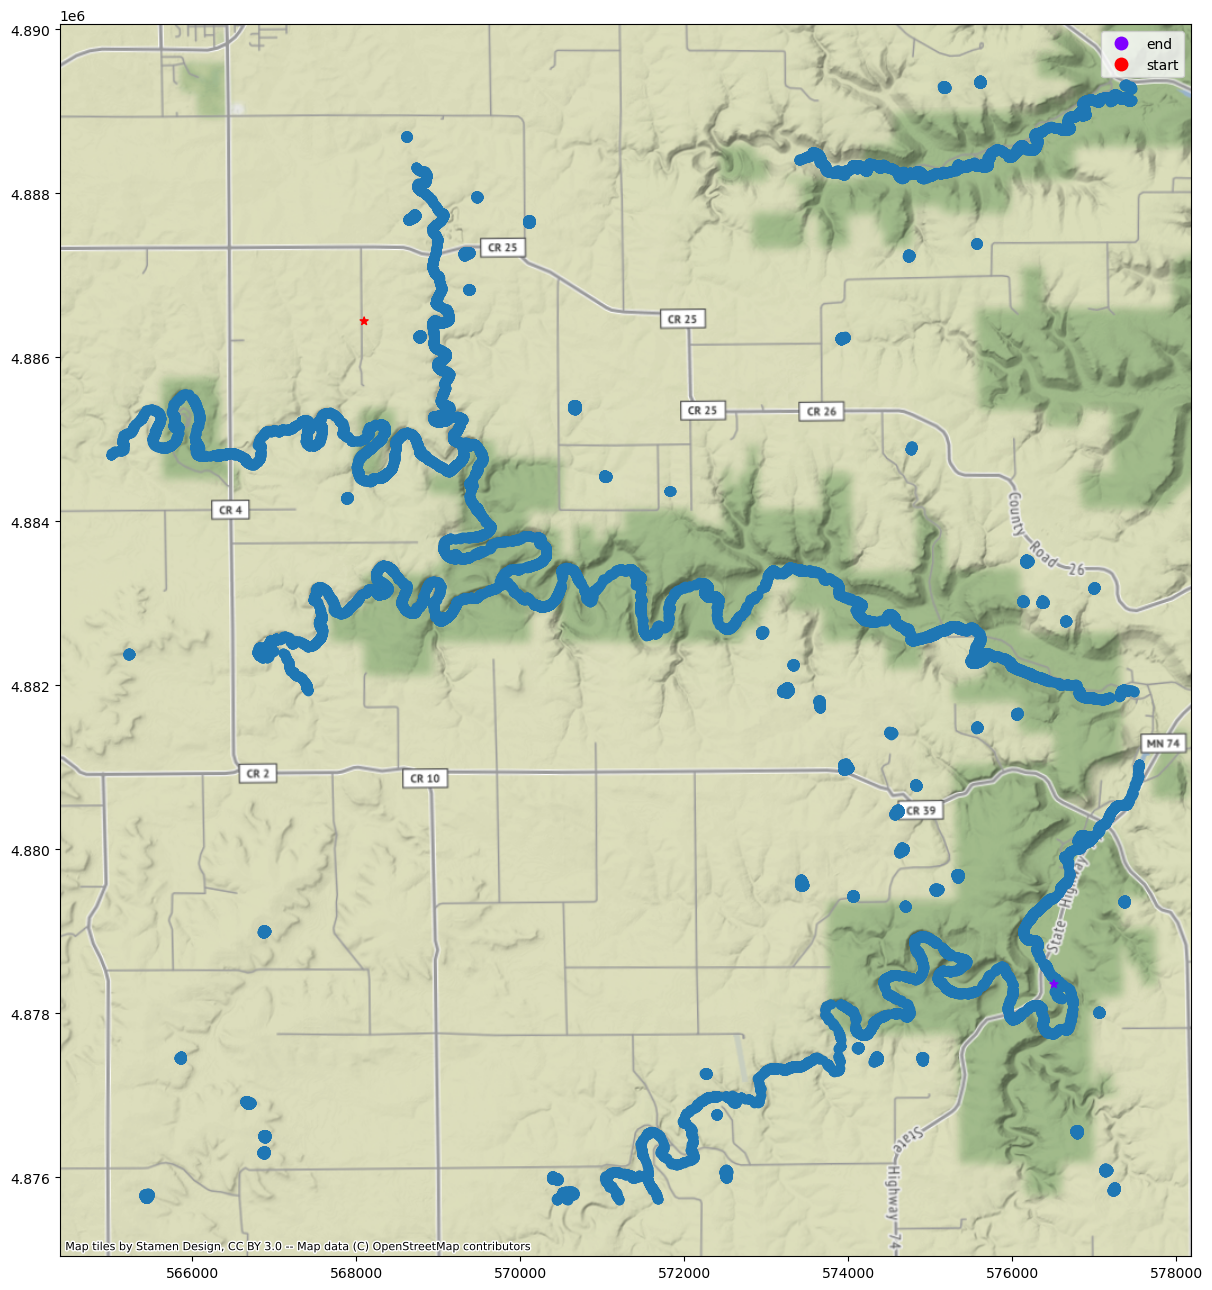

In [6]:
# Plot water and trip points

trip = gpd.read_file('DoryTrip.geojson')

trip = trip.to_crs('EPSG:26915')

f, ax = plt.subplots(1,1, figsize = (16,16))

ax.scatter(water_x/100, water_y/100) # The points are in centimeters!?

trip.plot(column = 'type', cmap = 'rainbow', legend = True, marker = '*', ax = ax)

ctx.add_basemap(ax = ax,
                crs = trip.crs)

plt.show()

In [7]:
# Yeah, that checks out. A Treacherous journey!

extent = minx_meters, miny_meters, maxx_meters, maxy_meters = (minx/100, miny/100, maxx/100, maxy/100)

height = extent[3] - extent[1]
width = extent[2] - extent[0]

print('height = ', height/1000, 'kilometers, width = ', width/1000, 'kilometers')

height =  14.018769999999552 kilometers, width =  12.658089999999968 kilometers


### Create Raster

In [8]:
# Create raster

resolution = 10 # Want maybe 10 x 10m meter cells

x_correction = resolution - np.mod(width, resolution) # It won't be perfect unless we add these
y_correction = resolution - np.mod(height, resolution)

# Split correction amongst min & maxs

new_minx = minx_meters - x_correction/2
new_maxx = maxx_meters + x_correction/2
new_miny = miny_meters - y_correction/2
new_maxy = maxy_meters + y_correction/2

# New heights

new_height = new_maxy - new_miny
new_width = new_maxx - new_minx

print('Corrected Height (for 10m resolution) = ', height, 'width = ', width)

x_cells = new_width/resolution
y_cells = new_height/resolution

print('x_cells = ', x_cells, '\ny_cells = ', y_cells)

Corrected Height (for 10m resolution) =  14018.769999999553 width =  12658.089999999967
x_cells =  1266.0 
y_cells =  1402.0


## Save

In [14]:
# Save Template as a GeoTiff

array_temp = np.empty([int(x_cells), int(y_cells)])

save_geotiff(array_temp, 'template', 26915, resolution, new_minx, new_miny)

# Save Template as a Numpy Grid (for plotting)
# Must mannually input cells from above.......

raster = np.mgrid[new_minx:new_maxx:1266j,
              new_miny:new_maxy:1402j]

np.save('template', raster)